<a href="https://colab.research.google.com/github/barksdaleaz/big_transfer/blob/master/20210312_big_transfer_tf2_amber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 Google LLC.



In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/big_transfer/blob/master/colabs/big_transfer_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# BigTransfer (BiT): A step-by-step tutorial for state-of-the-art vision

The original notebook for this tutorial in Big Transfer transfer learning was created by Jessica Yung and Joan Puigcerver of Google Brain in Zürich.  As part of New York University's CS-GY 6613 Introduction to AI with Professor Pantelis Monogioudis, it has been altered by Amber Barksdale and Russell Wustenberg.

In this lab, we will load the BiT-M model trained on the ImageNet-21k dataset with a ResNet50x3 architecutre.  It is based on the [BigTransfer paper](https://arxiv.org/abs/1912.11370) and accompanied by our own reflections on transfer learning, co-located in this repository.


In [ ]:
#@title Imports
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_datasets as tfds

import time

from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

import os
import pathlib

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension.
%load_ext tensorboard
from datetime import datetime
import io
import itertools
from packaging import version

from tensorflow import keras

import sklearn.metrics

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.4.1


In [ ]:
#@title Construct imagenet logit-to-class-name dictionary (imagenet_int_to_str)

!wget https://storage.googleapis.com/bit_models/imagenet21k_wordnet_lemmas.txt

imagenet_int_to_str = {}

with open('imagenet21k_wordnet_lemmas.txt', 'r') as f:
  for i in range(1000):
    row = f.readline()
    row = row.rstrip()
    imagenet_int_to_str.update({i: row})

--2021-03-12 19:50:42--  https://storage.googleapis.com/bit_models/imagenet21k_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 522999 (511K) [text/plain]
Saving to: ‘imagenet21k_wordnet_lemmas.txt.7’

imagenet21k_wordnet 100%[===================>] 510.74K  --.-KB/s    in 0.003s  

2021-03-12 19:50:42 (155 MB/s) - ‘imagenet21k_wordnet_lemmas.txt.7’ saved [522999/522999]



In [ ]:
#@title CIFAR-10 Label Names
cifar_10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Load the pre-trained BiT model

From the 10 available models, we chose to use a ResNet50x3 trained on ImageNet-21k.  We chose this model because it provides a complex enough architecture to see valid test results after fine-stream tuning, but simple enough to run on a publicly available Google CoLab notebook.  Available models 

In [ ]:
# Load model into KerasLayer
model_url = "https://tfhub.dev/google/bit/m-r50x3/1"
module = hub.KerasLayer(model_url)

In [ ]:
#@title Helper functions for loading image (hidden)

def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)  
  return image

def load_image_from_url(url):
  """Returns an image with shape [1, height, width, num_channels]."""
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

In [ ]:
#@title Plotting helper functions (hidden)
#@markdown Credits to Xiaohua Zhai, Lucas Beyer and Alex Kolesnikov from Brain Zurich, Google Research

# Show the MAX_PREDS highest scoring labels:
MAX_PREDS = 5
# Do not show labels with lower score than this:
MIN_SCORE = 0.8 

def show_preds(logits, image, correct_cifar_label=None, cifar_logits=False):

  if len(logits.shape) > 1:
    logits = tf.reshape(logits, [-1])

  fig, axes = plt.subplots(1, 2, figsize=(7, 4), squeeze=False)

  ax1, ax2 = axes[0]

  ax1.axis('off')
  ax1.imshow(image)
  if correct_cifar_label is not None:
    ax1.set_title(cifar_10_labels[correct_cifar_label])
  classes = []
  scores = []
  logits_max = np.max(logits)
  softmax_denominator = np.sum(np.exp(logits - logits_max))
  for index, j in enumerate(np.argsort(logits)[-MAX_PREDS::][::-1]):
    score = 1.0/(1.0 + np.exp(-logits[j]))
    if score < MIN_SCORE: break
    if not cifar_logits:
      # predicting in imagenet label space
      classes.append(imagenet_int_to_str[j])
    else:
      # predicting in tf_flowers label space
      classes.append(cifar_10_labels[j])
    scores.append(np.exp(logits[j] - logits_max)/softmax_denominator*100)

  ax2.barh(np.arange(len(scores)) + 0.1, scores)
  ax2.set_xlim(0, 100)
  ax2.set_yticks(np.arange(len(scores)))
  ax2.yaxis.set_ticks_position('right')
  ax2.set_yticklabels(classes, rotation=0, fontsize=14)
  ax2.invert_xaxis()
  ax2.invert_yaxis()
  ax2.set_xlabel('Prediction probabilities', fontsize=11)

Our BiT-M currently is trained for the ImageNet-21k classification labels.  It does not have the proper logit-to-label output for our target dataset the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), which has also been used in [other tutorials](https://www.tensorflow.org/tutorials/load_data/images). This dataset contains 60,000 images of 10 classes.

In order to re-map the logits to the correct labels, we must *fine tune* the model onto the new output.

In [ ]:
# Import CIFAR-10 data from tfds

# using below to load entire data set for test purposes only
ds, info2 = tfds.load(
    name='cifar10',
    split='train',
    with_info=True,
)

# using below to load only 100 images
train_10_20_ds, info = tfds.load(
    name='cifar10', 
    split='train[10:110]',
    with_info=True
    )

num_examples = info.splits['train[10:110]'].num_examples
num_examples2 = info2.splits['train'].num_examples
NUM_CLASSES = 10


In [ ]:
# Split into train and test sets
train_split = 0.9
num_train = int(train_split * num_examples2)

# Train_10_20_DS_Train should equal 100 images
train_10_20_ds_train = train_10_20_ds.take(100)

# here we use DS_TEST because it holds the entire 50,000 set
ds_test = ds.skip(num_train)

# DATASET_NUM_TRAIN_EXAMPLES = num_examples
DATASET_NUM_TRAIN_EXAMPLES = 100

## Fine-tuning the BiT model

As in the BiT tutorial, we are going to fine-tune the BiT model so it performs better on the CIFAR-10 dataset (`cifar_10`). 

There are two steps:
1. Create a new model with a new final layer (which is called the ‘head’), and
2. Fine-tune this model using BiT-HyperRule, the hyperparameter heuristic proposed by BiT.


In [ ]:
#@title BiT With a new head
# Add new head to the BiT model

class MyBiTModel(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')
    self.bit_model = module
  
  def call(self, images):
    # No need to cut head off since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = MyBiTModel(num_classes=NUM_CLASSES, module=module)

### Data and preprocessing



In [ ]:
#@title Appling the BiT HyperRule

#@markdown The BiT-HyperRule is a heuristic for setting hyperparameters for the
#@markdown BiT models.  It takes a number of decisions into account for optimization
#@markdown for a full overview of the code, [see here](https://github.com/google-research/big_transfer).
#@markdown Due to the low-shot nature of our training in this example, we will not
#@markdown be utilizing mixup, which is advised by BiT for only tasks > 20,000 samples. 
#@markdown 
#@markdown The creators of the tutorial utilized a pre-programmed dropdown menu for
#@markdown HyperRule selection and we have chosen to leave this intact for our experiment.

IMAGE_SIZE = "=\u003C96x96 px" #@param ["=<96x96 px","> 96 x 96 px"]
DATASET_SIZE = "\u003C20k examples" #@param ["<20k examples", "20k-500k examples", ">500k examples"]

if IMAGE_SIZE == "=<96x96 px":
  RESIZE_TO = 160
  CROP_TO = 128
else:
  RESIZE_TO = 512
  CROP_TO = 480

if DATASET_SIZE == "<20k examples":
  SCHEDULE_LENGTH = 500
  SCHEDULE_BOUNDARIES = [200, 300, 400]
elif DATASET_SIZE == "20k-500k examples":
  SCHEDULE_LENGTH = 10000
  SCHEDULE_BOUNDARIES = [3000, 6000, 9000]
else:
  SCHEDULE_LENGTH = 20000
  SCHEDULE_BOUNDARIES = [6000, 12000, 18000]

In [ ]:
#@title Preprocessing Helper Functions
# Preprocessing helper functions

# Create data pipelines for training and testing:
# Batch size was decreased due to an OOM error (Resource Exhausted)
BATCH_SIZE = 200
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

STEPS_PER_EPOCH = 10

def cast_to_tuple(features):
  return (features['image'], features['label'])
  
def preprocess_train(features):
  # Apply random crops and horizontal flips for all tasks 
  # except those for which cropping or flipping destroys the label semantics
  # (e.g. predict orientation of an object)
  features['image'] = tf.image.random_flip_left_right(features['image'])
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.image.random_crop(features['image'], [CROP_TO, CROP_TO, 3])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

def preprocess_test(features):
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

pipeline_train = (train_10_20_ds_train
                  .shuffle(10000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  # repeat dataset_size / num_steps
                  .map(preprocess_train, num_parallel_calls=8)
                  .batch(BATCH_SIZE)
                  .map(cast_to_tuple)  # for keras model.fit
                  .prefetch(2))

# note that ds_test is used for the testing pipeline, whereas
# train_10_20_ds_train is used only for the training
pipeline_test = (ds_test.map(preprocess_test, num_parallel_calls=1)
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(2))

### Fine-tuning loop

The below code will fine tune the model using our reduced training sample set taken from the CIFAR-10.  There are between 1 and 10 samples from each class contained within, and expected accuracy given such conditions will be between 75% and 88% accuracy.

In [ ]:
# Define optimiser and loss

lr = 0.003 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

# Fine-tune model
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=10,
    #epochs= int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
    validation_data=pipeline_test  # here we are only using 
                                   # this data to evaluate our performance
)

Epoch 1/10
10/10 [==============================] - 69s 6s/step - loss: 1.3326 - accuracy: 0.6494 - val_loss: 0.3945 - val_accuracy: 0.8694
Epoch 2/10
10/10 [==============================] - 49s 5s/step - loss: 0.0198 - accuracy: 0.9980 - val_loss: 0.3647 - val_accuracy: 0.8788
Epoch 3/10
10/10 [==============================] - 49s 5s/step - loss: 0.0039 - accuracy: 0.9995 - val_loss: 0.3585 - val_accuracy: 0.8860
Epoch 4/10
10/10 [==============================] - 49s 5s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.3596 - val_accuracy: 0.8860
Epoch 5/10
10/10 [==============================] - 49s 5s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3586 - val_accuracy: 0.8870
Epoch 6/10
10/10 [==============================] - 49s 5s/step - loss: 9.3866e-04 - accuracy: 1.0000 - val_loss: 0.3606 - val_accuracy: 0.8870
Epoch 7/10
10/10 [==============================] - 49s 5s/step - loss: 7.9560e-04 - accuracy: 1.0000 - val_loss: 0.3632 - val_accuracy: 0.8858
Epoch 8/10
1

#Assess the model performance 

We trained the model five times from-scratch on the limited data set pulled from CIFAR-10.  As stated before, between 1 to 10 samples per class were present in the mini-set with a total of 100 samples.  The following plots show the results.

In [ ]:
#@title Training Run Data

run_1_accuracy_turns_to_one = [.6482, .9988, .9995, 1.0]
run_2_accuracy_turns_to_one = [.9998, .9992, 1.0, 1.0]
run_3_accuracy_turns_to_one = [.6450, .9984, 1.0, 1.0]
run_4_accuracy_turns_to_one = [.6472, .9999, 1.0, 1.0]
run_5_accuracy_turns_to_one = [.6494, .9980, .9995, 1.0]

run_1_val_loss = [.3799, .3505, .3454, .3510, .3591, .3635, .3651, .3623, .3568, .3532]
run_2_val_loss = [.3485, .3406, .3469, .3478, .3491, .3504, .3501, .3487, .3459, .3441]
run_3_val_loss = [.3821, .3256, .3292, .3365, .3411, .3490, .3525, .3517, .3463, .3442]
run_4_val_loss = [.3966, .3687, .3654, .3706, .3746, .3757, .3741, .3686, .3659, .3617]
run_5_val_loss = [.3945, .3647, .3585, .3596, .3586, .3606, .3632, .3626, .3601, .3582]

run_1_val_accuracy = [.8766, .8832, .8926, .8916, .8890, .8878, .8864, .8876, .8902, .8912]
run_2_val_accuracy = [.8846, .8920, .8928, .8928, .8908, .8908, .8906, .8916, .8924, .8930]
run_3_val_accuracy = [.8744, .8942, .8984, .8974, .8950, .8930, .8910, .8922, .8934, .8938]
run_4_val_accuracy = [.8724, .8734, .8806, .8816, .8824, .8824, .8824, .8830, .8838, .8852]
run_5_val_accuracy = [.8694, .8788, .8860, .8860, .8870, .8870, .8858, .8874, .8886, .8898]

In [ ]:
#@title Plotter Helper Functions

def plot_accuracy(run_1, run_2, run_3, run_4, run_5):
  fig, ax = plt.subplots()

  ax.set_title('Comparison of Model Accuracy on Training Set')
  ax.set_xlabel('Epoch Number')
  ax.set_ylabel('Model Accuracy')
  ax.plot(range(0,4), run_1, color='tab:red',alpha=1.0)
  ax.plot(range(0,4), run_2, color='tab:green',alpha=1.0)
  ax.plot(range(0,4), run_3, color='tab:purple',alpha=1.0)
  ax.plot(range(0,4), run_4, color='tab:orange',alpha=1.0)
  ax.plot(range(0,4), run_5, color='tab:blue',alpha=1.0)
  plt.show()

def plot_val_loss(run_1, run_2, run_3, run_4, run_5):
  fig, ax = plt.subplots()

  ax.set_title('Comparison of Model Validation Loss on Test Set')
  ax.set_xlabel('Epoch Number')
  ax.set_ylabel('Validation Loss')
  ax.hist(run_1, color='tab:red',alpha=.5)
  ax.hist(run_2, color='tab:green',alpha=.5)
  ax.hist(run_3, color='tab:purple',alpha=.5)
  ax.hist(run_4, color='tab:orange',alpha=.5)
  ax.hist(run_5, color='tab:blue',alpha=.5)
  plt.show()

def plot_val_accuracy(run_1, run_2, run_3, run_4, run_5):
  fig, ax = plt.subplots(figsize=(10,5))

  ax.set_title('Model Validation Accuracy on Five Runs')
  ax.set_xlabel('Epoch Number')
  ax.set_ylabel('Model Validation Accuracy')
  ax.plot(range(0,10),run_1, color='tab:red',alpha=.7)
  ax.plot(range(0,10),run_2, color='tab:orange',alpha=.7)
  ax.plot(range(0,10),run_3, color='tab:green',alpha=.7)
  ax.plot(range(0,10),run_4, color='tab:purple',alpha=.7)
  ax.plot(range(0,10),run_5, color='tab:blue',alpha=.7)
  plt.axis([-1,10,.86,.9])
  plt.show()


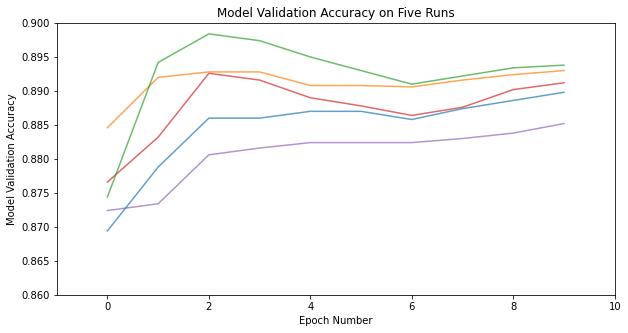

In [ ]:
#@title Plotting Model Accuracy on Training Set
# plot_accuracy(run_1_accuracy_turns_to_one, run_2_accuracy_turns_to_one, 
#              run_3_accuracy_turns_to_one, run_4_accuracy_turns_to_one,
#              run_5_accuracy_turns_to_one)
# plot_val_loss(run_1_val_loss, run_2_val_loss, run_3_val_loss, 
#              run_4_val_loss, run_5_val_loss)
plot_val_accuracy(run_1_val_accuracy, run_2_val_accuracy, run_3_val_accuracy,
                  run_4_val_accuracy, run_5_val_accuracy)

As seen above, the validation accuracy is within the expected limits (regularly scoring on multiple runs between .868 and .886).  The model took few turns (typically 4 or fewer) to reach 100% accuracy on the test set at which point the learning rate plateaued and accuracy and loss remained stable.

## Save fine-tuned model for later use

The following cell saves the fine tuned model for later use.


In [ ]:
# Save fine-tuned model as SavedModel
export_module_dir = '/tmp/my_saved_bit_model/'
tf.saved_model.save(model, export_module_dir)

INFO:tensorflow:Assets written to: /tmp/my_saved_bit_model/assets


INFO:tensorflow:Assets written to: /tmp/my_saved_bit_model/assets


The following cell loads the fine tuned model for use.

In [ ]:
# Load saved model
saved_module = hub.KerasLayer(export_module_dir, trainable=True)

As can be seen in the predictions below, images run through the model are now correlated to their proper CIFAR-10 classifications.  The model has been tuned and is ready for further experimentation.

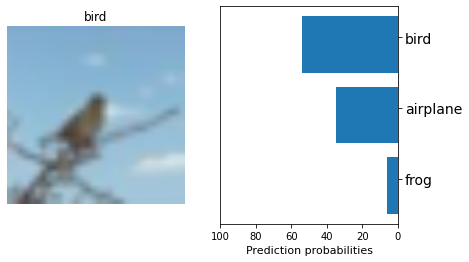

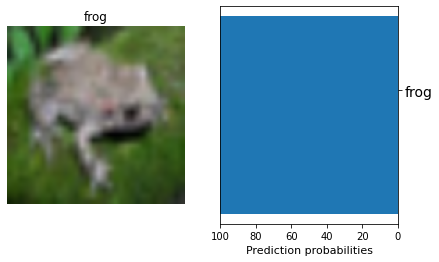

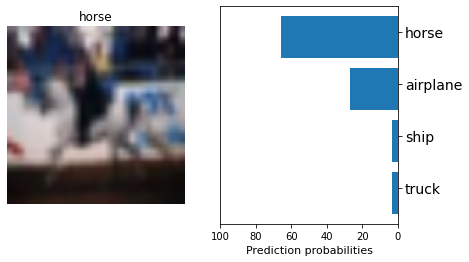

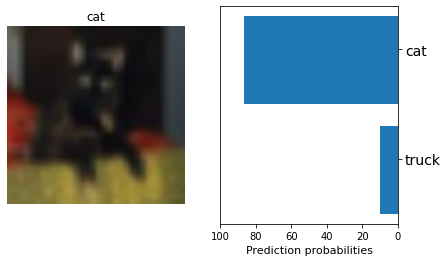

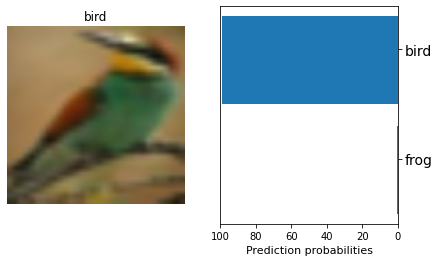

In [ ]:
# Visualise predictions from new model

test_accuracy = tf.keras.metrics.Accuracy()

# Show the MAX_PREDS highest scoring labels:
MAX_PREDS = 5
# Do not show labels with lower score than this:
MIN_SCORE = 0.8 

for features in ds_test.take(5):
  image = features['image']
  image = preprocess_image(image)
  image = tf.image.resize(image, [CROP_TO, CROP_TO])

  # Run model on image
  logits = saved_module(image)
 
  # Show image and predictions
  show_preds(logits, image[0], correct_cifar_label=features['label'].numpy(), cifar_logits=True)

## Summary

In this post, you learned about the key components we used to train models that can transfer well to many different tasks. You also learned how to load one of our BiT models, fine-tune it on your target task and save the resulting model. Hope this helped and happy fine-tuning!


## Acknowledgements

This colab is based on work by Alex Kolesnikov, Lucas Beyer, Xiaohua Zhai, Joan Puigcerver, Jessica Yung, Sylvain Gelly and Neil Houlsby. We thank many members of Brain Research Zurich and the TensorFlow team for their feedback, especially Luiz Gustavo Martins and Marcin Michalski.
